Binomial tree model dated back to Cox, Ross and Rubinstein (1979). It can be conveniently used to value European options and in particular American options which do not have analytical formulas. 

For all the examples below, we assume the same conditions as the classical Black-Scholes model for example constant risk-free interest rate $r$  and constant volatility $\sigma$ except that the underlying stock dynamics follows now a binomial tree. 

We consider an Bemurda option with strike price $K$, maturity time $T$ on an **non-dividend-paying** underlying stock with initial price $S_0$. 

In [ ]:
# few tasks and manipulations on data sets
import math
import numpy as np
import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'

import matplotlib.pyplot as plt
plt.style.use('seaborn')
# Parameters -- American Put Option
S0 = 100.  # initial stock level
T = 0.1  # time-to-maturity
r = 0.06  # short rate
sigma = 0.2  # volatility
K= 106.

In [2]:
#### GENERATE Stock Price Tree
def getSmatrix1(S0, sigma,T, M):
    dt = T / M  # length of time interval
    # Binomial Parameters
    u = np.exp(sigma * np.sqrt(dt))  # up-factor
    d = 1 / u  # down-factor
    S = np.zeros((M+1,M+1)) # make an empty matrix of m+1 X m+1 
    S[0,:] = S0 #set the initial value of the tree equal to S0
    mu = np.arange(M + 1) # return evenly spaced values within a given interval.
    S[0,:] = S[0,:]*(u**mu)
    for k in range(1, M + 1):
        # time  goes from left to right
        S[k,k:M+1] = S[k - 1, k-1:M] *d
    return S

In [3]:
#### Exact price for the European option price
from scipy.stats import norm #import norm
def bs(S0, K, T, r, sigma): #define the function
    d1= (np.log(S0/K)+(r+0.5*(sigma**2))*T)/(sigma*np.sqrt(T)) #calculate d1
    d2= d1-sigma*np.sqrt(T) #calculate d2
    c= S0*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2) #the price of the european call option
    p = c+K*np.exp(-r*T)-S0 #the price of the european put option
    return c, p #return both c and p

###  Bemurda option pricing via binomial tree

Pricing a Bemurda option via binomial tree method is simlar to pricing an American option. The difference is we check early-exercising possiblities only at a certain set of exercising dates. 

Suppose that for this Bemurda option, we have 10 evenly-spaced early exercising dates. 

For example,  if we have a 500 step tree, the early exercising dates are: step 0, step 50, step 100, step 150, step 200, step 250, step 300, step 350, step 400, step 450

### The task
Let the proxy exact price (the benchmark) be the tree price with 10000 time steps. 

Price your Bermuda option with time steps in the following range and make a convergence plot. 

**mmin, mmax, step_size = (10, 1011, 30)**

In [4]:
#### Taking the code from Lecture 4 solution to self-checking exercise on early...
def CRR_option_Bermuda(S0, K, T, r, sigma, M=10, isPut = True):
   
    ''' Cox-Ross-Rubinstein Amerian option valuation.

    Parameters
    ==========
    S0, K, T, r, sigma : float, parameters as we usually use   
    M : int
        number of time intervals
    isPut: American put or American call
    control: use control variate or not
    '''
    # Time Parameters
    dt = T / M  # length of time interval
    df = math.exp(-r * dt)  # discount per interval

    # Binomial Parameters
    u = math.exp(sigma * math.sqrt(dt))  # up-factor
    d = 1 / u  # down-factor
    q = (math.exp(r * dt) - d) / (u - d)  # risk-neutral probability
    
    
    # Array Initialization for asset prices
    S = getSmatrix1(S0, sigma, T, M)
    
    # Inner Values
    #################### call or put##################
    if isPut:
        V = np.maximum(K-S, 0)  # put payoff at maturity        
    else:
        V = np.maximum(S-K, 0)  # call payoff at maturity
    
    V_euro = V.copy()  # payoffs for European counterpart
    z = 0
    # store all early exercise decisions at time 0 up to time M-1
    # (time M is maturity)
    exciseDecision = np.zeros((M, M))
    N = 10 #set the N equal to 10
    k = np.round(M/N) #
    exercise_dates = np.arange(N+1)*k
    # Backwards induction through time
    for t in range(M - 1, -1, -1):  
        #print('at time step', t)
        #print('compute for', M-z, 'prices at once')
        #print(S[0: M - z, t].shape)
        alive = (q * V[0:M - z, t + 1] + (1 - q) * V[1:M - z + 1, t + 1]) * df
        dead = S[0:M - z, t]- K 
        # check the exercise dates every 100 steps
        # and return the maximum otherwise the alive 
        if(t in exercise_dates):
            optionValue=np.maximum(alive,dead)
        else:
            optionValue = alive;
        #the other part I left the same 
        # at t-th column, compute for 0-th to "M-z"th rows (all values are zero below)
        # European counterpart, for control variate
        V_euro[0:M - z, t] = (q * V_euro[0:M - z, t + 1] + (1 - q) * V_euro[1:M - z + 1, t + 1]) * df
        
        # American option values at time t
        V[0:M - z, t] = optionValue
        exciseDecision[0:M - z, t] = (dead > alive)
        z+=1
    # option value
    result = V[0, 0]

    return result, exciseDecision, V_euro[0,0] 

In [5]:
put_exact= CRR_option_Bermuda(S0, K, T, r, sigma, 10000, True) #proxy as exact

In [6]:
exactPut = put_exact[0] # check the first node
exactPut #print the value

6.722421005851225

In [7]:
mmin, mmax, step_size = (10, 1011, 30) #set the mmin mmax and the step size for the bermuda call option
exact = exactPut #set the exact equal to exactCall for reading purposes
m = range(mmin, mmax, step_size)
Bermuda_values = [CRR_option_Bermuda(S0, K, T, r, sigma, M, True)[0] for M in m] # here basically we make
# the for loop that checks for different m values from 10 to 1011 with a step size of 30
# Bermuda_values

(0.0, 1011.0)

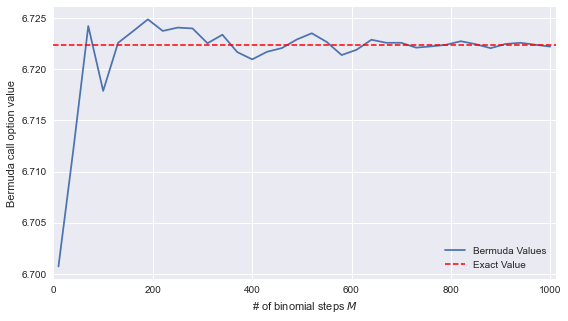

In [8]:
plt.figure(figsize=(9, 5)) #make the figure
plt.plot(m, Bermuda_values, label='Bermuda Values') #plot the figure

plt.axhline(exact, color='r', ls='dashed', lw=1.5, # input the the legend
            label='Exact Value')
plt.xlabel('# of binomial steps $M$') #xlabel headling
plt.ylabel('Bermuda call option value') #ylabel headling
plt.legend(loc=4) #set the location of the legend
plt.xlim(0, mmax) # zero to max number of the binomial steps M 
# here basically we can see the benchmark the exact value versus the bermuda values we got
# with the given outputs and range of M

### Download and save surf2016DecABBcall.csv, read this csv file using pandas, do some manipulations

In [1]:
# read surf2016DecABBcall.csv
import  pandas as pd
import matplotlib.pyplot as plt

df_raw = pd.read_csv('surf2016DecABBcall.csv', sep = ';') #the default for sep is ','
df = df_raw.copy()
print('Using \'df_raw.columns\':', df_raw.columns)
# five columns 

Using 'df_raw.columns': Index(['Date', 'Tau', 'strike', 'impVol', 'spot'], dtype='object')


In [10]:
df_raw.head() #getting the very 5 first rows

,Date,Tau,strike,impVol,spot
0,2016-12-01,30,198.1286,0.187224,189.2043
1,2016-12-01,30,196.3948,0.188071,189.2043
2,2016-12-01,30,194.8300,0.188588,189.2043
3,2016-12-01,30,193.4096,0.190119,189.2043
4,2016-12-01,30,192.0795,0.193358,189.2043


In [11]:
df_raw.tail() #getting the very 5 last rows

,Date,Tau,strike,impVol,spot
2725,2016-12-30,730,180.5899,0.199519,191.7322
2726,2016-12-30,730,175.7418,0.201208,191.7322
2727,2016-12-30,730,171.2513,0.201760,191.7322
2728,2016-12-30,730,166.6254,0.201876,191.7322
2729,2016-12-30,730,162.0706,0.202030,191.7322


In [12]:
type(df_raw) # getting the type of the df_raw which is a dataframe Pandas object
# An object is simply a collection variables and functions that act on variables

pandas.core.frame.DataFrame

In [13]:
columns_to_drop= ['Date', 'Tau', 'strike'] #erase some of the columns 

# drop a column, using 'inplace = True' if you want your dataframe get changed
df_raw.drop(columns_to_drop, axis='columns', inplace = True)
df_raw

,impVol,spot
0,0.187224,189.2043
1,0.188071,189.2043
2,0.188588,189.2043
3,0.190119,189.2043
4,0.193358,189.2043
...,...,...
2725,0.199519,191.7322
2726,0.201208,191.7322
2727,0.201760,191.7322
2728,0.201876,191.7322


In [14]:
print('Unique strike prices by using set:', 
      set(df_raw['spot']), "Number of unique strike prices: ", len(set(df_raw['spot'])))
# set here is giving back only the unique items of the data frame 

Unique strike prices by using set: {191.7322, 189.2043, 190.8685, 189.3327, 190.4567, 191.4544, 192.9288, 191.3819, 194.6536, 195.0148, 195.4935, 196.7592, 196.8766, 197.2914, 194.8286, 193.6082, 194.4704, 194.3158, 191.9728, 192.9417, 194.6076} Number of unique strike prices:  21


In [15]:
df_raw.describe() #using describe to get some info

,impVol,spot
count,2730.000000,2730.000000
mean,0.194301,193.342557
std,0.017257,2.339134
min,0.131982,189.204300
25%,0.185570,191.454400
50%,0.193883,193.608200
75%,0.202388,194.828600
max,0.313243,197.291400


In [16]:
df #here call the copy to keep doing things

,Date,Tau,strike,impVol,spot
0,2016-12-01,30,198.1286,0.187224,189.2043
1,2016-12-01,30,196.3948,0.188071,189.2043
2,2016-12-01,30,194.8300,0.188588,189.2043
3,2016-12-01,30,193.4096,0.190119,189.2043
4,2016-12-01,30,192.0795,0.193358,189.2043
...,...,...,...,...,...
2725,2016-12-30,730,180.5899,0.199519,191.7322
2726,2016-12-30,730,175.7418,0.201208,191.7322
2727,2016-12-30,730,171.2513,0.201760,191.7322
2728,2016-12-30,730,166.6254,0.201876,191.7322


In [17]:
# call size which basically calculates the above 2730rows x 5columns
df.size

13650

In [18]:
# .pop() is basically doing almost the same thing as drop() however it also returns the column or row 
# for us to examine with the name, length and the type
df.pop("Tau")

0        30
1        30
2        30
3        30
4        30
       ... 
2725    730
2726    730
2727    730
2728    730
2729    730
Name: Tau, Length: 2730, dtype: int64

In [19]:
# sorts the corresponding column / there is not NaN value
df.sort_values(by=['strike'], na_position = "first")

,Date,strike,impVol,spot
129,2016-12-01,152.7878,0.251801,189.2043
909,2016-12-09,154.8411,0.249893,191.3819
779,2016-12-08,155.1900,0.241213,190.4567
116,2016-12-01,155.9176,0.251287,189.2043
259,2016-12-02,156.5201,0.225937,189.3327
...,...,...,...,...
1027,2016-12-12,235.1814,0.189582,194.6536
1677,2016-12-19,235.9224,0.184348,196.8766
1417,2016-12-15,236.0214,0.188959,195.4935
1547,2016-12-16,236.5856,0.186148,196.7592


In [20]:
df

,Date,strike,impVol,spot
0,2016-12-01,198.1286,0.187224,189.2043
1,2016-12-01,196.3948,0.188071,189.2043
2,2016-12-01,194.8300,0.188588,189.2043
3,2016-12-01,193.4096,0.190119,189.2043
4,2016-12-01,192.0795,0.193358,189.2043
...,...,...,...,...
2725,2016-12-30,180.5899,0.199519,191.7322
2726,2016-12-30,175.7418,0.201208,191.7322
2727,2016-12-30,171.2513,0.201760,191.7322
2728,2016-12-30,166.6254,0.201876,191.7322


In [21]:
df.columns #getting the columns

Index(['Date', 'strike', 'impVol', 'spot'], dtype='object')

In [22]:
df.index #getting range

RangeIndex(start=0, stop=2730, step=1)

In [23]:
df.values # getting an np array

array([['2016-12-01', 198.1286, 0.1872241, 189.2043],
       ['2016-12-01', 196.3948, 0.1880708, 189.2043],
       ['2016-12-01', 194.83, 0.188588, 189.2043],
       ...,
       ['2016-12-30', 171.2513, 0.2017596, 191.7322],
       ['2016-12-30', 166.6254, 0.2018756, 191.7322],
       ['2016-12-30', 162.0706, 0.2020302, 191.7322]], dtype=object)

In [24]:
df.shape # a tuple of the rows and columns

(2730, 4)

In [25]:
df.dtypes #data types of each column

Date       object
strike    float64
impVol    float64
spot      float64
dtype: object

In [26]:
type(df['Date'][2729]) # type of the 2729th row of the column "Date"

str

In [27]:
type(df['Date']) #however the whole column all together is Series
# Series is a one-dimensional array holding data of any type

pandas.core.series.Series

In [28]:
strikes_ser = df['strike'].copy()

In [29]:
strikes_ser

0       198.1286
1       196.3948
2       194.8300
3       193.4096
4       192.0795
          ...   
2725    180.5899
2726    175.7418
2727    171.2513
2728    166.6254
2729    162.0706
Name: strike, Length: 2730, dtype: float64

In [30]:
type(strikes_ser) #since it is a single column, you get a Series

pandas.core.series.Series

In [31]:
strikes_df = df[['strike']].copy() #to get a dataframe enclose the [] into [[]]
type(strikes_df)

pandas.core.frame.DataFrame

In [32]:
# for one column
df['strike']

0       198.1286
1       196.3948
2       194.8300
3       193.4096
4       192.0795
          ...   
2725    180.5899
2726    175.7418
2727    171.2513
2728    166.6254
2729    162.0706
Name: strike, Length: 2730, dtype: float64

In [33]:
# for multiple columns
# my guess here is that [] waits for a single column of series only 
#whereas the [[]] is dataframe friendly
df[['strike', 'impVol']]

,strike,impVol
0,198.1286,0.187224
1,196.3948,0.188071
2,194.8300,0.188588
3,193.4096,0.190119
4,192.0795,0.193358
...,...,...
2725,180.5899,0.199519
2726,175.7418,0.201208
2727,171.2513,0.201760
2728,166.6254,0.201876


In [34]:
type(df[['strike', 'impVol']])

pandas.core.frame.DataFrame

In [35]:
# adding a new column 
df

,Date,strike,impVol,spot
0,2016-12-01,198.1286,0.187224,189.2043
1,2016-12-01,196.3948,0.188071,189.2043
2,2016-12-01,194.8300,0.188588,189.2043
3,2016-12-01,193.4096,0.190119,189.2043
4,2016-12-01,192.0795,0.193358,189.2043
...,...,...,...,...
2725,2016-12-30,180.5899,0.199519,191.7322
2726,2016-12-30,175.7418,0.201208,191.7322
2727,2016-12-30,171.2513,0.201760,191.7322
2728,2016-12-30,166.6254,0.201876,191.7322


In [36]:
df['Maturity'] = 0

In [37]:
df

,Date,strike,impVol,spot,Maturity
0,2016-12-01,198.1286,0.187224,189.2043,0
1,2016-12-01,196.3948,0.188071,189.2043,0
2,2016-12-01,194.8300,0.188588,189.2043,0
3,2016-12-01,193.4096,0.190119,189.2043,0
4,2016-12-01,192.0795,0.193358,189.2043,0
...,...,...,...,...,...
2725,2016-12-30,180.5899,0.199519,191.7322,0
2726,2016-12-30,175.7418,0.201208,191.7322,0
2727,2016-12-30,171.2513,0.201760,191.7322,0
2728,2016-12-30,166.6254,0.201876,191.7322,0


In [38]:
df.drop(['Date', 'strike'], axis='columns') # removed in place only changes the view and not the actual
# dataframe

,impVol,spot,Maturity
0,0.187224,189.2043,0
1,0.188071,189.2043,0
2,0.188588,189.2043,0
3,0.190119,189.2043,0
4,0.193358,189.2043,0
...,...,...,...
2725,0.199519,191.7322,0
2726,0.201208,191.7322,0
2727,0.201760,191.7322,0
2728,0.201876,191.7322,0


In [39]:
df 

,Date,strike,impVol,spot,Maturity
0,2016-12-01,198.1286,0.187224,189.2043,0
1,2016-12-01,196.3948,0.188071,189.2043,0
2,2016-12-01,194.8300,0.188588,189.2043,0
3,2016-12-01,193.4096,0.190119,189.2043,0
4,2016-12-01,192.0795,0.193358,189.2043,0
...,...,...,...,...,...
2725,2016-12-30,180.5899,0.199519,191.7322,0
2726,2016-12-30,175.7418,0.201208,191.7322,0
2727,2016-12-30,171.2513,0.201760,191.7322,0
2728,2016-12-30,166.6254,0.201876,191.7322,0


In [40]:
df3 = df.copy();
df.drop(['Date', 'strike'], axis='columns', inplace = True) # now we changed it 

In [41]:
df3.loc[100] # getting the element with index 100

Date        2016-12-01
strike         177.651
impVol         0.21293
spot          189.2043
Maturity             0
Name: 100, dtype: object

In [42]:
df3.iloc[-1] # taking the last row of the dataframe

Date        2016-12-30
strike        162.0706
impVol         0.20203
spot          191.7322
Maturity             0
Name: 2729, dtype: object

In [43]:
df3.iloc[[1,20, -1]] # getting the row of index 1 20 and the last element

,Date,strike,impVol,spot,Maturity
1,2016-12-01,196.3948,0.188071,189.2043,0
20,2016-12-01,187.7259,0.202807,189.2043,0
2729,2016-12-30,162.0706,0.202030,191.7322,0


In [44]:
df3.iloc[:,0:2].head() # getting the columns from position 0 to 2

,Date,strike
0,2016-12-01,198.1286
1,2016-12-01,196.3948
2,2016-12-01,194.8300
3,2016-12-01,193.4096
4,2016-12-01,192.0795


In [45]:
df3.loc[(df3['Date']=='2016-12-01'),: ] # getting the specific date for as many as elements have it

,Date,strike,impVol,spot,Maturity
0,2016-12-01,198.1286,0.187224,189.2043,0
1,2016-12-01,196.3948,0.188071,189.2043,0
2,2016-12-01,194.8300,0.188588,189.2043,0
3,2016-12-01,193.4096,0.190119,189.2043,0
4,2016-12-01,192.0795,0.193358,189.2043,0
...,...,...,...,...,...
125,2016-12-01,178.3924,0.208396,189.2043,0
126,2016-12-01,173.1494,0.213982,189.2043,0
127,2016-12-01,168.0735,0.217054,189.2043,0
128,2016-12-01,162.0359,0.224124,189.2043,0


In [46]:
df3.loc[(df3['Date']=="2016-12-01") & (df3["impVol"]<0.19),: ] # use boolean values

,Date,strike,impVol,spot,Maturity
0,2016-12-01,198.1286,0.187224,189.2043,0
1,2016-12-01,196.3948,0.188071,189.2043,0
2,2016-12-01,194.8300,0.188588,189.2043,0


In [47]:
df3.loc[(df3['Date']!="2016-12-01") & (df3["impVol"]<0.19),: ]

,Date,strike,impVol,spot,Maturity
130,2016-12-02,197.5552,0.173279,189.3327,0
131,2016-12-02,196.2241,0.180672,189.3327,0
132,2016-12-02,194.3735,0.170299,189.3327,0
133,2016-12-02,192.4638,0.145230,189.3327,0
134,2016-12-02,191.1981,0.131982,189.3327,0
...,...,...,...,...,...
2667,2016-12-30,204.7476,0.188514,191.7322,0
2668,2016-12-30,201.4568,0.189159,191.7322,0
2704,2016-12-30,226.4355,0.188863,191.7322,0
2717,2016-12-30,231.1474,0.188238,191.7322,0


In [48]:
df3.loc[(df3['Date']!="2016-12-01") & (df3["impVol"]<0.19),: ]

,Date,strike,impVol,spot,Maturity
130,2016-12-02,197.5552,0.173279,189.3327,0
131,2016-12-02,196.2241,0.180672,189.3327,0
132,2016-12-02,194.3735,0.170299,189.3327,0
133,2016-12-02,192.4638,0.145230,189.3327,0
134,2016-12-02,191.1981,0.131982,189.3327,0
...,...,...,...,...,...
2667,2016-12-30,204.7476,0.188514,191.7322,0
2668,2016-12-30,201.4568,0.189159,191.7322,0
2704,2016-12-30,226.4355,0.188863,191.7322,0
2717,2016-12-30,231.1474,0.188238,191.7322,0


In [49]:
df_part = df3.loc[(df3['Date']=="2016-12-01") | (df3["impVol"]<0.19),: ].copy()

In [50]:
df_part

,Date,strike,impVol,spot,Maturity
0,2016-12-01,198.1286,0.187224,189.2043,0
1,2016-12-01,196.3948,0.188071,189.2043,0
2,2016-12-01,194.8300,0.188588,189.2043,0
3,2016-12-01,193.4096,0.190119,189.2043,0
4,2016-12-01,192.0795,0.193358,189.2043,0
...,...,...,...,...,...
2667,2016-12-30,204.7476,0.188514,191.7322,0
2668,2016-12-30,201.4568,0.189159,191.7322,0
2704,2016-12-30,226.4355,0.188863,191.7322,0
2717,2016-12-30,231.1474,0.188238,191.7322,0


In [51]:
df_part.reset_index(drop=True, inplace = True)

In [52]:
df_part

,Date,strike,impVol,spot,Maturity
0,2016-12-01,198.1286,0.187224,189.2043,0
1,2016-12-01,196.3948,0.188071,189.2043,0
2,2016-12-01,194.8300,0.188588,189.2043,0
3,2016-12-01,193.4096,0.190119,189.2043,0
4,2016-12-01,192.0795,0.193358,189.2043,0
...,...,...,...,...,...
1127,2016-12-30,204.7476,0.188514,191.7322,0
1128,2016-12-30,201.4568,0.189159,191.7322,0
1129,2016-12-30,226.4355,0.188863,191.7322,0
1130,2016-12-30,231.1474,0.188238,191.7322,0


### Plotting the volatility smiles for some maturities. One smile for short maturity, one smile for long maturity.

In [53]:
import numpy as np
dataFrameNew = pd.read_csv('surf2016DecABBcall.csv', sep = ';') # read the csv file

In [54]:
dataFrameNew.tail(30)
# copy specific period of time
dataFrameNewShort = dataFrameNew.loc[(dataFrameNew['Tau']==30) & (dataFrameNew['Date']=="2016-12-01"),:].copy()
dataFrameNewLong = dataFrameNew.loc[(dataFrameNew['Tau']==730) & (dataFrameNew['Date']=="2016-12-01"),:].copy()
print(dataFrameNewShort)
print(dataFrameNewLong)

          Date  Tau    strike    impVol      spot
0   2016-12-01   30  198.1286  0.187224  189.2043
1   2016-12-01   30  196.3948  0.188071  189.2043
2   2016-12-01   30  194.8300  0.188588  189.2043
3   2016-12-01   30  193.4096  0.190119  189.2043
4   2016-12-01   30  192.0795  0.193358  189.2043
5   2016-12-01   30  190.7453  0.195264  189.2043
6   2016-12-01   30  189.4135  0.196262  189.2043
7   2016-12-01   30  188.0705  0.199346  189.2043
8   2016-12-01   30  186.6351  0.206180  189.2043
9   2016-12-01   30  185.0797  0.212522  189.2043
10  2016-12-01   30  183.2906  0.222165  189.2043
11  2016-12-01   30  180.8653  0.244011  189.2043
12  2016-12-01   30  177.5061  0.276382  189.2043
           Date  Tau    strike    impVol      spot
117  2016-12-01  730  231.0856  0.197242  189.2043
118  2016-12-01  730  221.7080  0.198278  189.2043
119  2016-12-01  730  213.4618  0.198843  189.2043
120  2016-12-01  730  206.2189  0.200052  189.2043
121  2016-12-01  730  200.1817  0.203414  189

0     198.1286
1     196.3948
2     194.8300
3     193.4096
4     192.0795
5     190.7453
6     189.4135
7     188.0705
8     186.6351
9     185.0797
10    183.2906
11    180.8653
12    177.5061
Name: strike, dtype: float64 0     0.187224
1     0.188071
2     0.188588
3     0.190119
4     0.193358
5     0.195264
6     0.196262
7     0.199346
8     0.206180
9     0.212522
10    0.222165
11    0.244011
12    0.276382
Name: impVol, dtype: float64


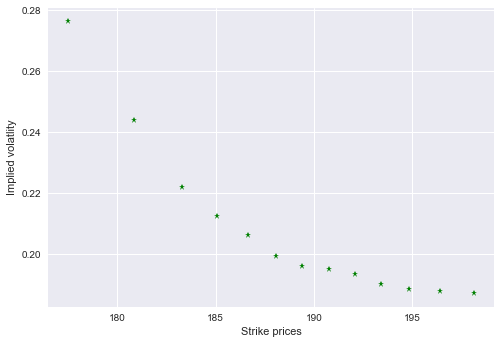

In [55]:
fig, ax1 = plt.subplots()
x = dataFrameNewShort['strike'] # take it out [0:13]
y = dataFrameNewShort['impVol']
x
plt.grid(True)
plt.xlabel('Strike prices')
plt.ylabel('Implied volatlity')
#plt.plot(x,np.linspace(0, 20, 15), 'b', lw=1.5, label='price plot')
plt.plot(x,y, 'g*', lw=1.5, label='volatility smile')
print(x,y)

          Date  Tau    strike    impVol      spot
0   2016-12-01  730  231.0856  0.197242  189.2043
1   2016-12-01  730  221.7080  0.198278  189.2043
2   2016-12-01  730  213.4618  0.198843  189.2043
3   2016-12-01  730  206.2189  0.200052  189.2043
4   2016-12-01  730  200.1817  0.203414  189.2043
5   2016-12-01  730  194.3953  0.205373  189.2043
6   2016-12-01  730  188.7666  0.205728  189.2043
7   2016-12-01  730  183.4379  0.206053  189.2043
8   2016-12-01  730  178.3924  0.208396  189.2043
9   2016-12-01  730  173.1494  0.213982  189.2043
10  2016-12-01  730  168.0735  0.217054  189.2043
11  2016-12-01  730  162.0359  0.224124  189.2043
12  2016-12-01  730  152.7878  0.251801  189.2043


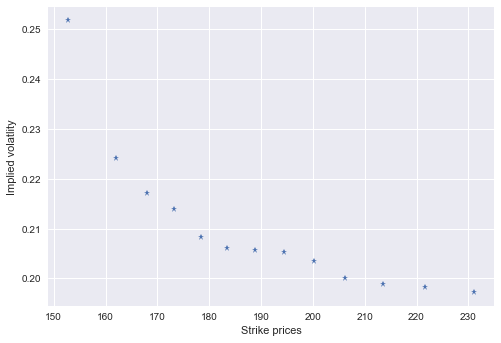

In [56]:
dataFrameNewLong.reset_index(drop=True, inplace = True)
fig, ax2 = plt.subplots()
print(dataFrameNewLong)
x1 = dataFrameNewLong['strike']
y1 = dataFrameNewLong['impVol']
plt.grid(True)
plt.xlabel('Strike prices')
plt.ylabel('Implied volatlity')
#plt.plot(x,np.linspace(0, 20, 15), 'b', lw=1.5, label='price plot')
plt.plot(x1,y1, '*', lw=1.5, label='volatility smile')


### Download a updated csv file of ABB option quotes from Nasdaq OMX Nordic. Write down the current date, read the csv file as pandas DataFrame, plot a volatility smile (skew) for one short maturity of your choice. Assume a value of the risk-free rate, assume there will not be any dividend paying.

In [58]:
## On the dataset
# We use ABB option quotes downloaded on 11th of November 2022 from Nasdaq OMX Nordic.
# https://www.nasdaqomxnordic.com/optionsandfutures/microsite?languageId=1&Instrument=SSE3966
import  pandas as pd
import matplotlib.pyplot as plt

In [59]:
# today's spot price of ABB at the time we downloaded the option quotes
S0= 305.10
# read the file
df_abb = pd.read_csv('ABB_CALL.csv',sep= ';', skiprows = 1) #the default for sep is ','
# it is kind of a weird thing getting a column at the end of the dataframe that is called
# Unnamed. However it should not be hard to drop these columns
df_abb.head(50)

,Name,Exp.,Bid,Ask,Last,High,Low,Openinterest,Volume,Underlying,Strike,Unnamed: 11
0,ABB2K03Y255,2022-11-03,47.75,51.75,NaN,NaN,NaN,NaN,NaN,100.0,255.00,NaN
1,ABB2K03Y260,2022-11-03,42.75,46.75,NaN,NaN,NaN,NaN,NaN,100.0,260.00,NaN
2,ABB2K03Y265,2022-11-03,37.75,41.75,NaN,NaN,NaN,NaN,NaN,100.0,265.00,NaN
3,ABB2K03Y270,2022-11-03,32.75,36.75,NaN,NaN,NaN,NaN,NaN,100.0,270.00,NaN
4,ABB2K03Y275,2022-11-03,28.00,31.25,NaN,NaN,NaN,NaN,NaN,100.0,275.00,NaN
5,ABB2K03Y280,2022-11-03,23.00,26.25,NaN,NaN,NaN,NaN,NaN,100.0,280.00,NaN
6,ABB2K03Y285,2022-11-03,18.50,21.00,NaN,NaN,NaN,NaN,NaN,100.0,285.00,NaN
7,ABB2K03Y290,2022-11-03,13.75,15.75,NaN,NaN,NaN,NaN,NaN,100.0,290.00,NaN
8,ABB2K03Y295,2022-11-03,9.30,10.50,9.5,NaN,NaN,5,NaN,100.0,295.00,NaN
9,ABB2K03Y300,2022-11-03,4.40,5.40,NaN,NaN,NaN,NaN,NaN,100.0,300.00,NaN


In [60]:
cols = list(pd.read_csv('ABB_CALL.csv', sep= ';', skiprows =1))
print(cols)
print('Using \'df_abb.columns\':', df_abb.columns)

['Name', 'Exp.', 'Bid', 'Ask', 'Last', 'High', 'Low', 'Openinterest', 'Volume', 'Underlying', 'Strike', 'Unnamed: 11']
Using 'df_abb.columns': Index(['Name', 'Exp.', 'Bid', 'Ask', 'Last', 'High', 'Low', 'Openinterest',
       'Volume', 'Underlying', 'Strike', 'Unnamed: 11'],
      dtype='object')


In [61]:
# set the columns we want to drop
columns_to_drop= ['Name', 'Last', 'High', 'Low', 'Openinterest', 'Volume', 'Underlying', 'Unnamed: 11']
df_abb.drop(columns_to_drop, axis='columns', inplace = True)

In [62]:
df= df_abb.copy()
df['MidPrice'] = (df['Bid']+df['Ask'])/2

In [63]:
df.drop(['Bid', 'Ask'], axis='columns', inplace = True) # try with removing inplace

In [64]:
df_part= df.loc[(df['MidPrice']>0.5) & (df['Exp.']=='2022-12-02'),: ].copy()
df_part.reset_index(drop=True, inplace = True)

In [65]:
import bisec_implied_vol as bis
# We assume interest rate is 2%
r = 0.02; 
# Maturity of 2nd of Dec, it is 21 trading days from 4th Nov. 
# we will look at the date time computations in a later lecture
T = 21/252
(rows, cols) = df_part.shape

In [66]:
rows

9

In [67]:
from numpy import exp, log, sqrt, array, zeros
imp = zeros(rows) #make an empty array
for row in range(rows): # then loop over the indices of the array and use the bis.bisecImp to calculate
    # the implied volatility
    imp[row] = bis.bisecIMP('C',S0, df_part['Strike'][row],r,T,0.01,1.5,df_part['MidPrice'][row])
    #print(impVol[row])
df_part['impVol']= imp #set a new column

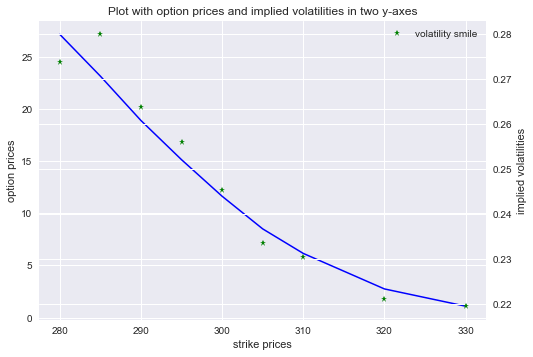

In [68]:
fig, ax1 = plt.subplots() # nrows=1, ncols=1 by default
y = df_part[['Strike', 'MidPrice', 'impVol']].copy() #make a dataframe copy with only these 3
#columns

plt.plot(y.iloc[:, 0],y.iloc[:, 1], 'b', lw=1.5, label='price plot') #use iloc to get the strike 
# and mid price
plt.grid(True)
#plt.legend(loc=8)
plt.axis('tight')
plt.xlabel('strike prices')
plt.ylabel('option prices')
plt.title('Plot with option prices and implied volatilities in two y-axes')

ax2 = ax1.twinx() #Note that ax2 is an Axes object,i.e. a new plotting area 
plt.plot(y.iloc[:, 0],y.iloc[:, 2], 'g*', lw=1.5, label='volatility smile') #strike and imp volatility
plt.legend(loc=0)
plt.ylabel('implied volatilities')
plt.show() #make a plot with the prices on the left and the implied volatility on the right x-axis
# and the strike prices on the y-axis

In [69]:
################### HOMEWORK6 Exercise1 ###################
import numpy as np
import math
import matplotlib.pyplot as plt
#change into your choices
mu = 0.1; sigma = 0.25; S0 = 100 
n_days = 252*2
# Simulate normal random numbers, the epsilons in the above scheme
rnd = np.random.standard_normal(n_days) # pseudorandom numbers

# each time step is one day
dt = 1/252 

stock  = np.zeros(n_days) 
stock[0] = S0

# simulate one trajecctory of stock price process that follows GBM
for t in range(1,n_days):
    stock[t] = stock[t - 1] * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * math.sqrt(dt) * rnd[t])
myDataFrame = pd.DataFrame()
myDataFrame.index = pd.date_range('2020-10-09',periods = 252*2, freq= 'D')
myDataFrame["Strike"] = stock
myDataFrame

,Strike
2020-10-09,100.000000
2020-10-10,98.921182
2020-10-11,98.066902
2020-10-12,97.619553
2020-10-13,97.763046
...,...
2022-02-20,152.353001
2022-02-21,149.640881
2022-02-22,149.213614
2022-02-23,146.332700


In [70]:
myDataFrame['Returns'] = np.log(myDataFrame['Strike']).diff() #use the diff to calculate the log returns

Text(0.5, 0.98, 'Strike prices, returns and rolling volatility')

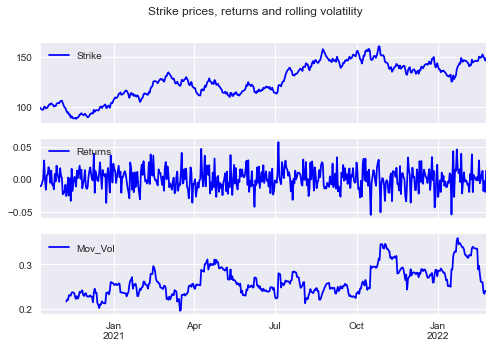

In [71]:
# calculating the rolling vol
# plotting 3 graphs with everything for the second bullt point of exercise 2
myDataFrame['Mov_Vol'] = myDataFrame['Returns'].rolling(window=30).std()*math.sqrt(252)
myDataFrame[['Strike', 'Returns','Mov_Vol']].plot(subplots=True, layout=(3,1), style='b',figsize=(8, 5), grid=True)
plt.suptitle('Strike prices, returns and rolling volatility') #make a title

In [72]:
resampledInto3Days = myDataFrame.resample(rule='3D', label='left') #every three days

In [73]:
resampledInto3Days.last()

,Strike,Returns,Mov_Vol
2020-10-09,98.066902,-0.008673,NaN
2020-10-12,100.612546,0.028730,NaN
2020-10-15,99.422625,0.005378,NaN
2020-10-18,103.157202,0.010539,NaN
2020-10-21,103.110577,-0.008393,NaN
...,...,...,...
2022-02-10,145.909260,0.000594,0.335946
2022-02-13,145.930855,-0.001899,0.288936
2022-02-16,149.154956,-0.000908,0.261360
2022-02-19,149.640881,-0.017962,0.237617


In [74]:
resampledInto3Days

In [75]:
################### HOMEWORK6 Exercise2 ###################
import pandas_datareader.data as web
symbols= ['^OMX', 'ABB',] # set the symbols
data =  web.DataReader(symbols,'yahoo', start="2012-10-21", end="2022-11-04")['Adj Close']
data['ABB']= data['ABB']*10.98 #as for 4th of November
data.tail(10)

Symbols,^OMX,ABB
Date,,
2022-10-24,1938.729980,301.730395
2022-10-25,1965.290039,307.440000
2022-10-26,1970.060059,310.404605
2022-10-27,1968.229980,306.451798
2022-10-28,1974.280029,307.659605
2022-10-31,1968.530029,305.683202
2022-11-01,1974.989990,308.428202
2022-11-02,1980.520020,300.961798
2022-11-03,1960.060059,299.314803


In [76]:
data['Returns of OMX'] = np.log(data['^OMX'] / data['^OMX'].shift(1)) #calculate the returns
data['Returns of ABB'] = np.log(data['ABB'] / data['ABB'].shift(1))

In [77]:
data.head(30)

Symbols,^OMX,ABB,Returns of OMX,Returns of ABB
Date,,,,
2012-10-22,1067.280029,151.647564,NaN,NaN
2012-10-23,1048.599976,146.533234,-0.017657,-0.034307
2012-10-24,1050.469971,145.448382,0.001782,-0.007431
2012-10-25,1057.739990,143.356134,0.006897,-0.014489
2012-10-26,1059.199951,140.953976,0.001379,-0.016899
2012-10-29,1055.569946,NaN,-0.003433,NaN
2012-10-30,1059.199951,NaN,0.003433,NaN
2012-10-31,1052.109985,139.946622,-0.006716,NaN
2012-11-01,1062.510010,141.806354,0.009836,0.013201


Text(0.5, 0.98, 'Returns of OMX and returns of ABB')

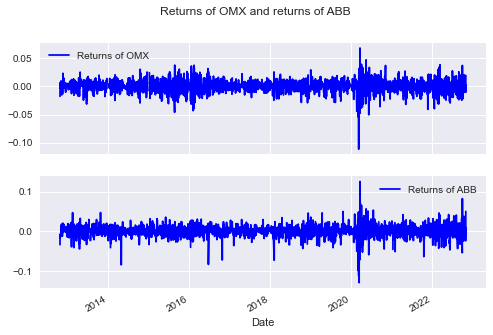

In [78]:
data[['Returns of OMX', 'Returns of ABB']].plot(subplots=True, layout=(2,1), style='b',figsize=(8, 5), grid=True)
plt.suptitle('Returns of OMX and returns of ABB')
# something noticable is the period of covid that we can clearly see that the volatility
# is higher than the usual
# pretty nice returns from both of the graphs though 
# they look similar

In [79]:
data.dropna(inplace=True) #drop the NaN values
returns = data[['Returns of OMX','Returns of ABB']].copy() #get only the returns
returns.head()

Symbols,Returns of OMX,Returns of ABB
Date,,
2012-10-23,-0.017657,-0.034307
2012-10-24,0.001782,-0.007431
2012-10-25,0.006897,-0.014489
2012-10-26,0.001379,-0.016899
2012-11-01,0.009836,0.013201


In [80]:
xdat = returns['Returns of OMX'].values # xdat is a numpy.ndarray
ydat = returns['Returns of ABB'].values

In [81]:
reg = np.polyfit(x=xdat, y=ydat, deg=1) #try with deg =2. 
reg  #coefficients in descending order

array([7.94651240e-01, 1.23176089e-04])

In [82]:
print(np.polyval(reg,0.05)) 

0.0398557380667507


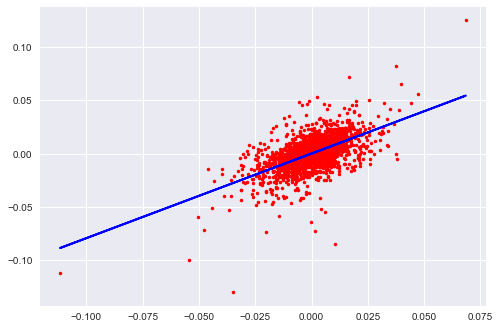

In [83]:
plt.plot(xdat, ydat, 'r.')
plt.plot(xdat, np.polyval(reg, xdat), 'b', lw=2)

In [84]:
returns.corr()

Symbols,Returns of OMX,Returns of ABB
Symbols,,
Returns of OMX,1.000000,0.588561
Returns of ABB,0.588561,1.000000
